In [1]:
import requests
from statistics import mean
import datetime
import json
from datetime import timedelta
import pandas as pd
from IPython.display import display
from dateutil.relativedelta import relativedelta
import seaborn as sns
pd.options.mode.chained_assignment = None 
from tqdm import tqdm
from tabulate import tabulate

In [2]:
import matplotlib.pyplot as plt

def cm_to_inch(value):
    return value/2.54
    
def plotWeights(data):  
    AVAXx = data[data.token_name=="AVAX"]["date"]
    AVAXy = data[data.token_name=="AVAX"]["weight"]
    BTCx = data[data.token_name=="WBTC.e"]["date"]
    BTCy = data[data.token_name=="WBTC.e"]["weight"]  
    ETHx = data[data.token_name=="WETH.e"]["date"]
    ETHy = data[data.token_name=="WETH.e"]["weight"]
    
    fig, axs = plt.subplots(figsize=(cm_to_inch(60),cm_to_inch(40)));
    axs.plot(AVAXx,AVAXy, color='mediumseagreen', linewidth=0.5, label = "AVAX", zorder=1)
    axs.plot(BTCx,BTCy, color='purple', linewidth=0.5, label = "WBTC.e", zorder=1)
    axs.plot(ETHx,ETHy, color='orange', linewidth=0.5, label = "WETH.e", zorder=1)
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    axs.set_ylabel("Weight")
    ax.legend()

In [3]:
# getting data from GMX

def create_options(query, skip_iterator):
    return query.replace('skip_param', str(skip_iterator))

# get date from poolAmount

def get_tokens_index():
    tokens = []
    query = '{"query":"{\\n tokenStats(first: 1000, orderBy: timestamp, orderDirection: desc, where : {timestamp_lt : skip_param}) {\\n period\\n poolAmount\\n poolAmountUsd\\n timestamp\\n token\\n}\\n}\\n","variables":null}'
    headers = {
        'authority': 'api.thegraph.com',
        'content-type': 'application/json',
        'accept': '*/*',
        'origin': 'https://thegraph.com',
        'sec-fetch-site': 'same-site',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': 'https://thegraph.com/',
    }
    timestamp = int(datetime.datetime.now().timestamp())
    timestampend = int((datetime.datetime.now()- relativedelta(months=6)).timestamp())
    while(timestamp >= timestampend):
        data = create_options(query, timestamp)
        response = requests.post('https://api.thegraph.com/subgraphs/name/gdev8317/gmx-avalanche-staging', headers = headers, data=data).json()["data"]["tokenStats"]
        if response:
            tokens.append(response)     
            timestamp = int(response[-1]['timestamp'])
        else:
            break
    return [item for sublist in tokens for item in sublist]

# get date from AUM (asset under management) and supply GLP for price calculation

def get_glp_price():
    prices = []
    query = '{"query":"{\\n glpStats(first: 1000, orderBy: timestamp, orderDirection: desc, where : {timestamp_lt : skip_param}) {\\n period\\n aumInUsdg\\n glpSupply\\n timestamp\\n}\\n}\\n","variables":null}'
    headers = {
        'authority': 'api.thegraph.com',
        'content-type': 'application/json',
        'accept': '*/*',
        'origin': 'https://thegraph.com',
        'sec-fetch-site': 'same-site',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': 'https://thegraph.com/',
    }
    timestamp = int(datetime.datetime.now().timestamp())
    timestampend = int((datetime.datetime.now()- relativedelta(months=6)).timestamp())
    while(timestamp >= timestampend):
        data = create_options(query, timestamp)
        response = requests.post('https://api.thegraph.com/subgraphs/name/gdev8317/gmx-avalanche-staging', headers = headers, data=data).json()["data"]["glpStats"]
        if response:
            prices.append(response)     
            timestamp = int(response[-1]['timestamp'])
        else:
            break
    return [item for sublist in prices for item in sublist]



In [4]:
tokens_buff = get_tokens_index()
tokens = pd.DataFrame(tokens_buff)

tokens['date'] = pd.to_datetime(tokens['timestamp'], unit = 's')
tokens

,period,poolAmount,poolAmountUsd,timestamp,token,date
0,hourly,21841336293383,21841336293383000000000000000000000000,1659873600,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e,2022-08-07 12:00:00
1,hourly,485328161565353047359505,12938848787332312242604403300000000000,1659873600,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,2022-08-07 12:00:00
2,hourly,25009504641654,25009504641654000000000000000000000000,1659873600,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,2022-08-07 12:00:00
3,hourly,65485413105,15119583828015296826021000000000000000,1659873600,0x50b7545627a5162f82a992c33b87adc75187b218,2022-08-07 12:00:00
4,hourly,8199704863668353574885,13936937443665319793898056676295800000,1659873600,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,2022-08-07 12:00:00
...,...,...,...,...,...,...
22995,hourly,86788604598344466558892,86788604598344466558892000000000000,1643940000,0x130966628846bfd36ff31a822705796e8cb8c18d,2022-02-04 02:00:00
22996,hourly,40454870506781131456012,2754715345880162181519890564400840000,1643936400,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,2022-02-04 01:00:00
22997,hourly,33067611118043,33067611118043000000000000000000000000,1643936400,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,2022-02-04 01:00:00
22998,hourly,33525919753,12476671036078950000000000000000000000,1643936400,0x50b7545627a5162f82a992c33b87adc75187b218,2022-02-04 01:00:00


In [5]:
price_buff = get_glp_price()
price = pd.DataFrame(price_buff)

price['date'] = pd.to_datetime(price['timestamp'], unit = 's')
price

,period,aumInUsdg,glpSupply,timestamp,date
0,daily,87499044979892911341507367,106732184960330813281869665,1659830400,2022-08-07
1,daily,87427793713311636738463058,106706424553357159391583141,1659744000,2022-08-06
2,daily,87008869682585946985094213,106461900158382161218432823,1659657600,2022-08-05
3,daily,87666509009484079184652640,110077451606377714287678458,1659571200,2022-08-04
4,daily,86770011191226854696791257,109209747740463591421871687,1659484800,2022-08-03
...,...,...,...,...,...
216,daily,2338987621295139304094,2504465602339074228422,1641168000,2022-01-03
217,daily,2084633599293917942158,2195383747037557386098,1641081600,2022-01-02
218,daily,1519930707009116128185,1654113337294739223685,1640822400,2021-12-30
219,total,87499044979892911341507367,106732184960330813281869665,1640131200,2021-12-22


In [6]:
tokens.period.unique()
# there is data for such periods: hourly', 'daily', 'weekly'

array(['hourly', 'daily', 'weekly'], dtype=object)

In [7]:
# I will use daily data in calculations

day_tokens = tokens[tokens.period == 'daily']
day_tokens

,period,poolAmount,poolAmountUsd,timestamp,token,date
66,daily,21841336293383,21841336293383000000000000000000000000,1659830400,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e,2022-08-07
67,daily,485328161565353047359505,12938848787332312242604403300000000000,1659830400,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,2022-08-07
68,daily,25009504641654,25009504641654000000000000000000000000,1659830400,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,2022-08-07
69,daily,65485413105,15119583828015296826021000000000000000,1659830400,0x50b7545627a5162f82a992c33b87adc75187b218,2022-08-07
70,daily,8199704863668353574885,13936937443665319793898056676295800000,1659830400,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,2022-08-07
...,...,...,...,...,...,...
22872,daily,56642970433691212118492,4382118843112671782619000316893800000,1644019200,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,2022-02-05
22873,daily,41966953568913,41966953568913000000000000000000000000,1644019200,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,2022-02-05
22874,daily,32941944253,13722204384836623076704300000000000000,1644019200,0x50b7545627a5162f82a992c33b87adc75187b218,2022-02-05
22875,daily,7355765512936331120881,22210513594123115553533132602824090000,1644019200,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,2022-02-05


In [8]:
day_price = price[price.period == 'daily']
day_price

,period,aumInUsdg,glpSupply,timestamp,date
0,daily,87499044979892911341507367,106732184960330813281869665,1659830400,2022-08-07
1,daily,87427793713311636738463058,106706424553357159391583141,1659744000,2022-08-06
2,daily,87008869682585946985094213,106461900158382161218432823,1659657600,2022-08-05
3,daily,87666509009484079184652640,110077451606377714287678458,1659571200,2022-08-04
4,daily,86770011191226854696791257,109209747740463591421871687,1659484800,2022-08-03
...,...,...,...,...,...
215,daily,7976086785799928354299,6700547234231331810624,1641254400,2022-01-04
216,daily,2338987621295139304094,2504465602339074228422,1641168000,2022-01-03
217,daily,2084633599293917942158,2195383747037557386098,1641081600,2022-01-02
218,daily,1519930707009116128185,1654113337294739223685,1640822400,2021-12-30


In [9]:
# price calculation

day_price["price"] = (day_price['aumInUsdg'].apply(int)) / (day_price['glpSupply'].apply(int))

In [10]:
day_tokens.poolAmountUsd.apply(int)

66       21841336293383000000000000000000000000
67       12938848787332312242604403300000000000
68       25009504641654000000000000000000000000
69       15119583828015296826021000000000000000
70       13936937443665319793898056676295800000
                          ...                  
22872     4382118843112671782619000316893800000
22873    41966953568913000000000000000000000000
22874    13722204384836623076704300000000000000
22875    22210513594123115553533132602824090000
22876       61453007081394372160676000000000000
Name: poolAmountUsd, Length: 1008, dtype: object

In [11]:
# calculation of weights for each token

Avalanche = {
  '0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7': 'AVAX',
  '0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab': 'WETH.e',
  '0x50b7545627a5162f82a992c33b87adc75187b218': 'WBTC.e',
  '0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664': 'USDC.e',
  '0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e': 'USDC',
  '0x130966628846bfd36ff31a822705796e8cb8c18d': 'MIM',}

stats_weight = []
    
for _, row in day_price.iterrows():
    
    date = row['timestamp']
    aum = row['aumInUsdg']
    tvl = day_tokens[day_tokens["timestamp"] == date]["poolAmountUsd"].apply(int).sum()
    for _, rowt in day_tokens[day_tokens["timestamp"] == date].iterrows():
        rowt["weight"] = 100 * int(rowt['poolAmountUsd']) / tvl
        rowt["token_name"] = Avalanche[rowt["token"]]
        stats_weight.append({
            'date' : rowt['date'],
            'token' : rowt['token'],
            'token_name' : rowt['token_name'],
            'weight' : rowt['weight'],
        })
stats_weight_d = pd.DataFrame(stats_weight)
stats_weight_d
        
        

,date,token,token_name,weight
0,2022-08-07,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e,USDC,24.582895
1,2022-08-07,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,AVAX,14.562953
2,2022-08-07,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,USDC.e,28.148737
3,2022-08-07,0x50b7545627a5162f82a992c33b87adc75187b218,WBTC.e,17.017418
4,2022-08-07,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,WETH.e,15.686324
...,...,...,...,...
1003,2022-02-05,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,AVAX,5.302959
1004,2022-02-05,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,USDC.e,50.785716
1005,2022-02-05,0x50b7545627a5162f82a992c33b87adc75187b218,WBTC.e,16.605732
1006,2022-02-05,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,WETH.e,26.877739


In [13]:
stats_weight_d[stats_weight_d.token_name=="WETH.e"].describe() 
# target 12.49 (from https://app.gmx.io/#/dashboard)   mean 16.662001

,weight
count,183.000000
mean,16.662001
std,3.250294
min,11.506634
25%,14.160145
50%,16.172425
75%,18.683642
max,28.046030


In [14]:
stats_weight_d[stats_weight_d.token_name=="AVAX"].describe() 
# target  12.49  (from https://app.gmx.io/#/dashboard) mean 11.785651

,weight
count,184.000000
mean,11.785651
std,3.508902
min,1.985103
25%,9.512812
50%,12.522089
75%,14.119549
max,21.820430


In [16]:
stats_weight_d[stats_weight_d.token_name=="WBTC.e"].describe() 
# target 24.99 (from https://app.gmx.io/#/dashboard) mean 17.209169

,weight
count,184.000000
mean,17.209169
std,2.986481
min,12.792089
25%,14.978122
50%,15.889669
75%,20.231938
max,24.809280


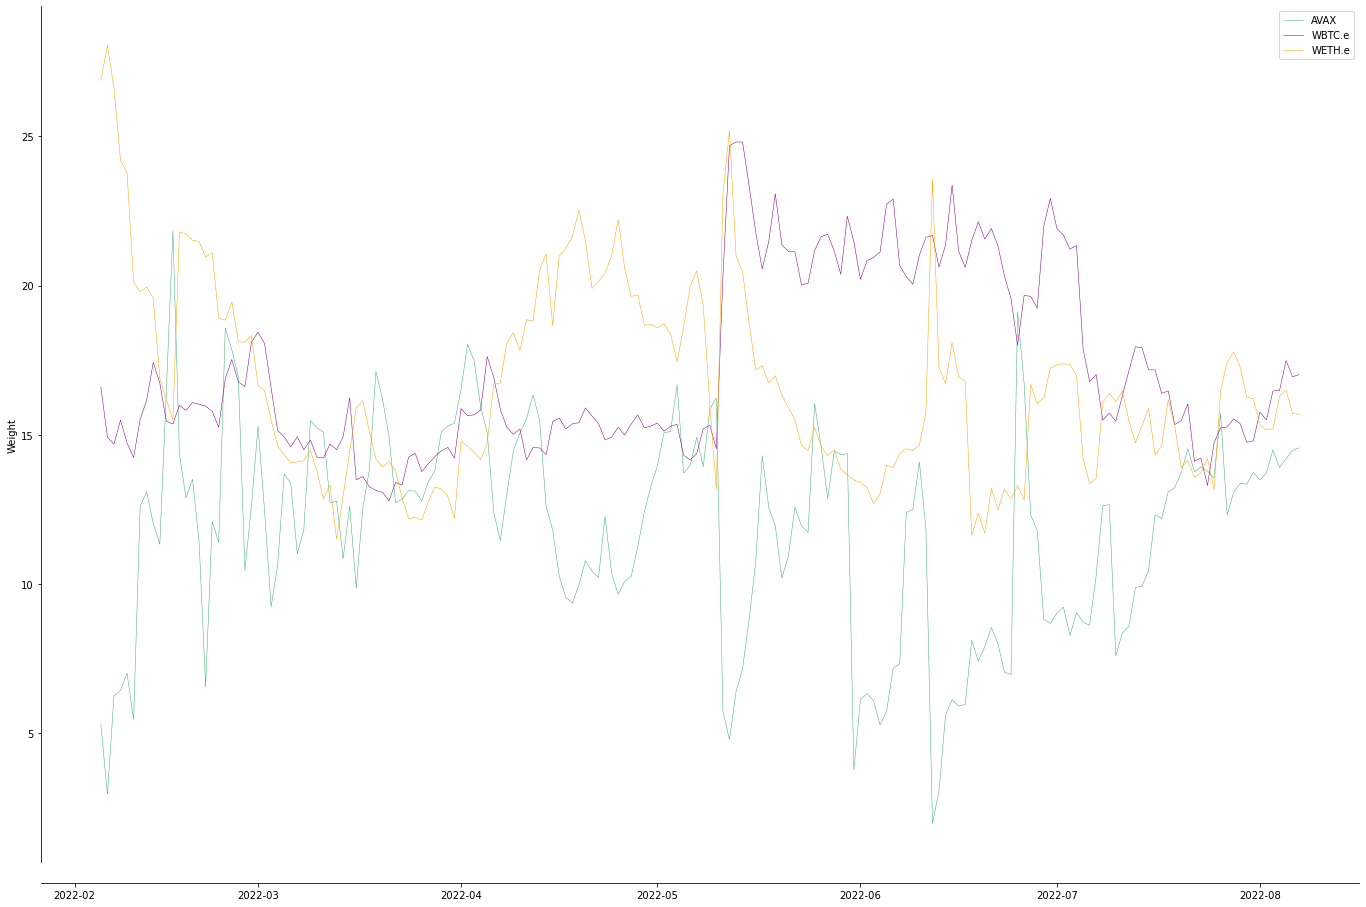

In [17]:
plotWeights(stats_weight_d[stats_weight_d["date"]> pd.to_datetime("2022-02-01")])

In [18]:
day_tokens

,period,poolAmount,poolAmountUsd,timestamp,token,date
66,daily,21841336293383,21841336293383000000000000000000000000,1659830400,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e,2022-08-07
67,daily,485328161565353047359505,12938848787332312242604403300000000000,1659830400,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,2022-08-07
68,daily,25009504641654,25009504641654000000000000000000000000,1659830400,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,2022-08-07
69,daily,65485413105,15119583828015296826021000000000000000,1659830400,0x50b7545627a5162f82a992c33b87adc75187b218,2022-08-07
70,daily,8199704863668353574885,13936937443665319793898056676295800000,1659830400,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,2022-08-07
...,...,...,...,...,...,...
22872,daily,56642970433691212118492,4382118843112671782619000316893800000,1644019200,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,2022-02-05
22873,daily,41966953568913,41966953568913000000000000000000000000,1644019200,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,2022-02-05
22874,daily,32941944253,13722204384836623076704300000000000000,1644019200,0x50b7545627a5162f82a992c33b87adc75187b218,2022-02-05
22875,daily,7355765512936331120881,22210513594123115553533132602824090000,1644019200,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,2022-02-05


In [19]:
day_price

,period,aumInUsdg,glpSupply,timestamp,date,price
0,daily,87499044979892911341507367,106732184960330813281869665,1659830400,2022-08-07,0.8198
1,daily,87427793713311636738463058,106706424553357159391583141,1659744000,2022-08-06,0.81933
2,daily,87008869682585946985094213,106461900158382161218432823,1659657600,2022-08-05,0.817277
3,daily,87666509009484079184652640,110077451606377714287678458,1659571200,2022-08-04,0.796408
4,daily,86770011191226854696791257,109209747740463591421871687,1659484800,2022-08-03,0.794526
...,...,...,...,...,...,...
215,daily,7976086785799928354299,6700547234231331810624,1641254400,2022-01-04,1.190363
216,daily,2338987621295139304094,2504465602339074228422,1641168000,2022-01-03,0.933927
217,daily,2084633599293917942158,2195383747037557386098,1641081600,2022-01-02,0.949553
218,daily,1519930707009116128185,1654113337294739223685,1640822400,2021-12-30,0.918879


In [20]:
stats_weight_d

,date,token,token_name,weight
0,2022-08-07,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e,USDC,24.582895
1,2022-08-07,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,AVAX,14.562953
2,2022-08-07,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,USDC.e,28.148737
3,2022-08-07,0x50b7545627a5162f82a992c33b87adc75187b218,WBTC.e,17.017418
4,2022-08-07,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,WETH.e,15.686324
...,...,...,...,...
1003,2022-02-05,0xb31f66aa3c1e785363f0875a1b74e27b85fd66c7,AVAX,5.302959
1004,2022-02-05,0xa7d7079b0fead91f3e65f86e8915cb59c1a4c664,USDC.e,50.785716
1005,2022-02-05,0x50b7545627a5162f82a992c33b87adc75187b218,WBTC.e,16.605732
1006,2022-02-05,0x49d5c2bdffac6ce2bfdb6640f4f80f226bc10bab,WETH.e,26.877739


period 177
count_rebalance 0
Earn                    USD         %
-----------------  --------  --------
glp earn            429.088   4.29088
loss/profit hedge  -220.938  -2.20938
total               208.151   2.08151


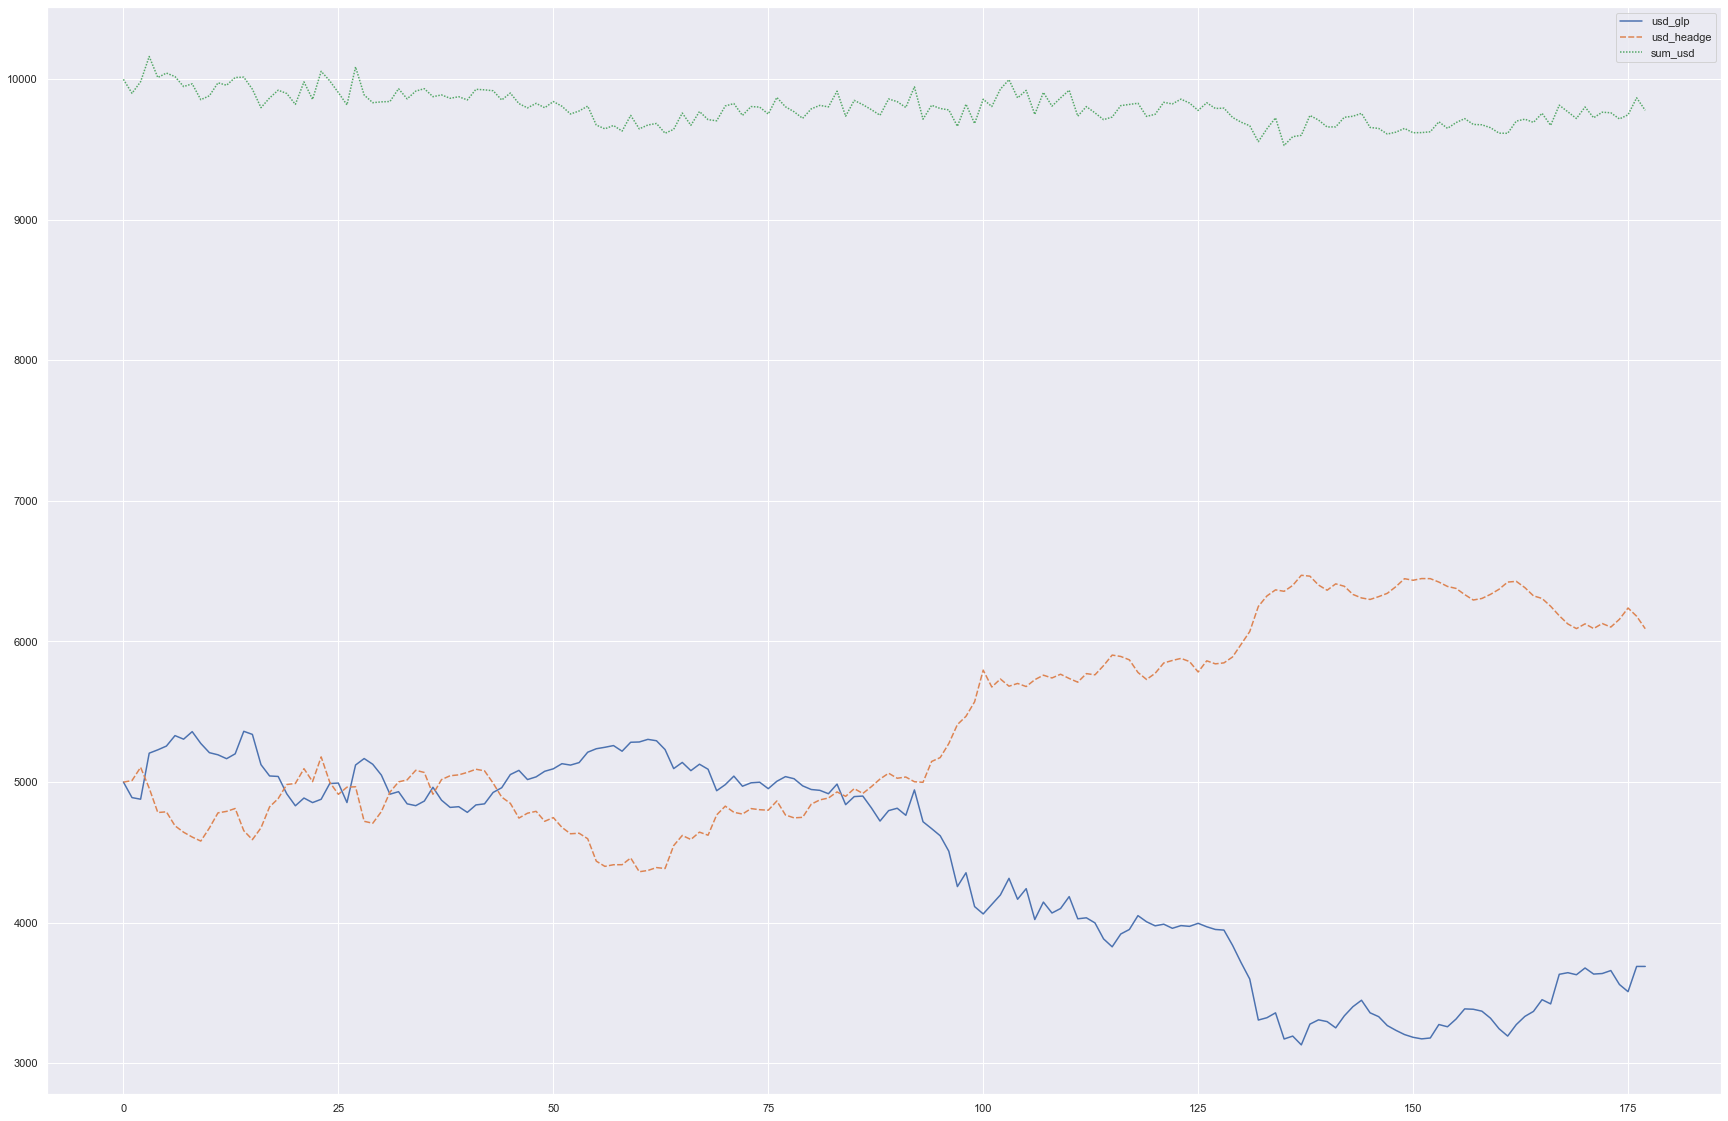

In [119]:
print_result(stats_usddf)